In [1]:
import ioutils as io
import skimage
from PIL import Image
import glob
import os
import natsort
import numpy as np
from skimage.transform import resize
import random
from tqdm import trange, tqdm
import open3d as o3d
import cv2
import multiprocessing as mp
import time
import sklearn.metrics as metrics
from pyquaternion import Quaternion
import math
import itertools
import sys
from collections import OrderedDict
import copy
import pickle
%matplotlib inline
import matplotlib.pyplot as plt

from torchvision import transforms
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from my_networks import scr_net, CreateDiscriminator, define_SCR
from scr_utils import *

import sys

import warnings
warnings.filterwarnings('ignore')

In [2]:
# camera intrinsic matrix path
K_path='/scratch/zq415/work/pose/data/transform/iPhoSilIntrinsicMat.json'
# point cloud data path
point_cloud_path='/scratch/zq415/work/pose/data/point_cloud/200827robotLab_TV_joint2.pts'

# test image, GT scene coordinate and pose path
test_pose_path = '/scratch/zq415/work/pose/data/final_test_poses'
test_img_path = '/scratch/zq415/work/pose/data/final_test_real_img'
test_scr_path = '/scratch/zq415/work/pose/data/final_test_scene_coords'

# testing batch size
test_batch_size = 300


In [3]:
if not os.path.exists('./data/parameters.pic'):
    pcd = o3d.io.read_point_cloud(point_cloud_path)
    K = np.asarray(io.load(K_path))
    pnts_array = np.asarray(pcd.points)
    # minimum coordinate and coordinate range for each axis (definded manually)
    ptp_min, ptp = np.array([-2.7, -8.6, -0.05]), np.array([5.8, 14.3, 3.05])
    mean_sc = ((pnts_array-ptp_min)/ptp).mean(0)
    mean_color = np.asarray(pcd.colors).mean(0)
    if not os.path.exists("./data"):
        os.mkdir("./data")
    dbfile = open('./data/parameters.pic', 'wb')      
    pickle.dump((ptp_min, ptp, mean_sc, mean_color, K), dbfile) 
    dbfile.close()
else:
    dbfile = open('./data/parameters.pic', 'rb')      
    ptp_min, ptp, mean_sc, mean_color, K = pickle.load(dbfile) 
    dbfile.close()
    

In [4]:
test_img_paths, test_scr_paths, test_pose_paths = get_test_paths(test_img_path, test_scr_path, test_pose_path)

real_test_dataset = dataset_scr(test_img_paths, test_pose_paths, test_scr_paths)
real_test_dataloader = DataLoader(real_test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=4)


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net_img_adapt = load_net('/scratch/zq415/work/pose/dance/check_point/scr_b48_e18_norm2_0118_train_his_cyclegan.pth', device)
#scr_b48_e19_norm2_0126_train_his_cut_l2loss

8it [00:48,  6.02s/it]
WARNING - 2021-03-08 12:17:02,592 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2104, 3, 45, 80) (2104, 3, 45, 80) (2104, 4, 4)


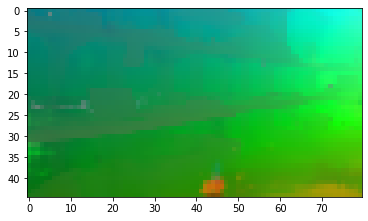

(2104, 3, 45, 80)


In [6]:
real_test_imgs, real_test_scr_predicts_imgada, real_scrs, Ts = test(net_img_adapt, real_test_dataloader, device)

print(real_test_scr_predicts_imgada.shape)


In [15]:
real_scrs_torch = torch.from_numpy(real_test_scr_predicts_imgada)
real_scrs_up = torch.nn.functional.interpolate(real_scrs_torch, scale_factor=4.0, mode='bicubic').numpy()
real_scrs_up = real_scrs_up.transpose(0,2,3,1)
real_scrs_up = np.clip(real_scrs_up, a_min=0, a_max=1)

predict_num = 2104
root_save_path = '/scratch/zq415/work/pose/data/final_test_scene_coords_pre/0'
for i in range(predict_num):
    print(i)
    scr_pre = real_scrs_up[i,...]
    
    if not os.path.exists(root_save_path):
        os.makedirs(root_save_path)
    img_save_name = os.path.join(root_save_path, str(i)+'.tiff')
    
    with io.AsyncSaver(max_queue_size=10) as saver:
        saver.save(img_save_name,  scr_pre)
        
        
        

saving: : 0it [00:00, ?it/s]

0


saving: 100%|██████████| 1/1 [00:00<00:00, 145.67it/s]
saving: : 0it [00:00, ?it/s]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


saving: 100%|██████████| 1/1 [00:00<00:00, 151.64it/s]
saving: : 0it [00:00, ?it/s]

33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66


saving: 100%|██████████| 1/1 [00:00<00:00, 204.42it/s]
saving: : 0it [00:00, ?it/s]

67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


saving: 100%|██████████| 1/1 [00:00<00:00, 198.13it/s]
saving: : 0it [00:00, ?it/s]

100
101
102
103
104
105
106
107
108
109
110
111
112
113
114


saving: 100%|██████████| 1/1 [00:00<00:00, 210.44it/s]
saving: : 0it [00:00, ?it/s]

115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147


saving: 100%|██████████| 1/1 [00:00<00:00, 159.18it/s]
saving: : 0it [00:00, ?it/s]

148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180


saving: 100%|██████████| 1/1 [00:00<00:00, 204.90it/s]
saving: : 0it [00:00, ?it/s]

181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213


saving: 100%|██████████| 1/1 [00:00<00:00, 208.86it/s]
saving: : 0it [00:00, ?it/s]

214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238


saving: 100%|██████████| 1/1 [00:00<00:00, 198.29it/s]
saving: : 0it [00:00, ?it/s]

239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270


saving: 100%|██████████| 1/1 [00:00<00:00, 187.72it/s]

271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301



saving: 100%|██████████| 1/1 [00:00<00:00, 244.61it/s]
saving: : 0it [00:00, ?it/s]

302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335


saving: 100%|██████████| 1/1 [00:00<00:00, 213.37it/s]
saving: : 0it [00:00, ?it/s]

336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368


saving: 100%|██████████| 1/1 [00:00<00:00, 209.53it/s]
saving: : 0it [00:00, ?it/s]

369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401


saving: 100%|██████████| 1/1 [00:00<00:00, 213.33it/s]

402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435



saving: 100%|██████████| 1/1 [00:00<00:00, 204.10it/s]
saving: : 0it [00:00, ?it/s]

436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469


saving: 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]
saving: : 0it [00:00, ?it/s]

470
471
472
473
474
475
476
477
478
479


saving: 100%|██████████| 1/1 [00:00<00:00, 207.78it/s]
saving: : 0it [00:00, ?it/s]

480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513


saving: 100%|██████████| 1/1 [00:00<00:00,  9.90it/s]
saving: : 0it [00:00, ?it/s]

514
515
516
517
518
519


saving: 100%|██████████| 1/1 [00:00<00:00, 175.31it/s]
saving: : 0it [00:00, ?it/s]

520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549


saving: 100%|██████████| 1/1 [00:00<00:00, 196.97it/s]
saving: : 0it [00:00, ?it/s]

550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582


saving: 100%|██████████| 1/1 [00:00<00:00, 208.89it/s]

583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614



saving: 100%|██████████| 1/1 [00:00<00:00, 193.88it/s]
saving: : 0it [00:00, ?it/s]

615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646


saving: 100%|██████████| 1/1 [00:00<00:00, 202.80it/s]
saving: : 0it [00:00, ?it/s]

647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678


saving: 100%|██████████| 1/1 [00:00<00:00, 201.70it/s]
saving: : 0it [00:00, ?it/s]

679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709


saving: 100%|██████████| 1/1 [00:00<00:00, 211.98it/s]

710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740



saving: 100%|██████████| 1/1 [00:00<00:00, 194.22it/s]


741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773


saving: 100%|██████████| 1/1 [00:00<00:00, 197.20it/s]
saving: : 0it [00:00, ?it/s]

774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804


saving: 100%|██████████| 1/1 [00:00<00:00, 205.80it/s]
saving: : 0it [00:00, ?it/s]

805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835


saving: 100%|██████████| 1/1 [00:00<00:00, 196.10it/s]

836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866



saving: 100%|██████████| 1/1 [00:00<00:00, 198.49it/s]
saving: : 0it [00:00, ?it/s]

867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898


saving: 100%|██████████| 1/1 [00:00<00:00, 193.13it/s]
saving: : 0it [00:00, ?it/s]

899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930


saving: 100%|██████████| 1/1 [00:00<00:00, 145.06it/s]
saving: : 0it [00:00, ?it/s]

931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958


saving: 100%|██████████| 1/1 [00:00<00:00, 142.51it/s]
saving: : 0it [00:00, ?it/s]

959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990


saving: 100%|██████████| 1/1 [00:00<00:00, 210.03it/s]
saving: : 0it [00:00, ?it/s]

991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022


saving: 100%|██████████| 1/1 [00:00<00:00, 194.06it/s]
saving: : 0it [00:00, ?it/s]

1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054


saving: 100%|██████████| 1/1 [00:00<00:00, 202.39it/s]
saving: : 0it [00:00, ?it/s]

1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086


saving: 100%|██████████| 1/1 [00:00<00:00, 148.66it/s]
saving: : 0it [00:00, ?it/s]

1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118


saving: 100%|██████████| 1/1 [00:00<00:00, 152.04it/s]
saving: : 0it [00:00, ?it/s]

1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150


saving: 100%|██████████| 1/1 [00:00<00:00, 143.64it/s]
saving: : 0it [00:00, ?it/s]

1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182


saving: 100%|██████████| 1/1 [00:00<00:00, 143.55it/s]
saving: : 0it [00:00, ?it/s]

1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214


saving: 100%|██████████| 1/1 [00:00<00:00, 147.19it/s]

1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246



saving: 100%|██████████| 1/1 [00:00<00:00, 150.84it/s]
saving: : 0it [00:00, ?it/s]

1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278


saving: 100%|██████████| 1/1 [00:00<00:00, 144.38it/s]
saving: : 0it [00:00, ?it/s]

1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1300
1301
1302
1303
1304
1305
1306
1307
1308
1309
1310


saving: 100%|██████████| 1/1 [00:00<00:00, 152.14it/s]
saving: : 0it [00:00, ?it/s]

1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342


saving: 100%|██████████| 1/1 [00:00<00:00, 152.06it/s]
saving: : 0it [00:00, ?it/s]

1343
1344
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374


saving: 100%|██████████| 1/1 [00:00<00:00, 146.80it/s]
saving: : 0it [00:00, ?it/s]

1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406


saving: 100%|██████████| 1/1 [00:00<00:00, 183.21it/s]
saving: : 0it [00:00, ?it/s]

1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438


saving: 100%|██████████| 1/1 [00:00<00:00, 204.49it/s]
saving: : 0it [00:00, ?it/s]

1439
1440
1441
1442
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469


saving: 100%|██████████| 1/1 [00:00<00:00, 146.92it/s]
saving: : 0it [00:00, ?it/s]

1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500


saving: 100%|██████████| 1/1 [00:00<00:00, 199.94it/s]
saving: : 0it [00:00, ?it/s]

1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531


saving: 100%|██████████| 1/1 [00:00<00:00, 151.53it/s]
saving: : 0it [00:00, ?it/s]

1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562


saving: 100%|██████████| 1/1 [00:00<00:00, 175.46it/s]
saving: : 0it [00:00, ?it/s]

1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593


saving: 100%|██████████| 1/1 [00:00<00:00, 152.00it/s]
saving: : 0it [00:00, ?it/s]

1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623


saving: 100%|██████████| 1/1 [00:00<00:00, 144.99it/s]
saving: : 0it [00:00, ?it/s]

1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654


saving: 100%|██████████| 1/1 [00:00<00:00, 145.66it/s]
saving: : 0it [00:00, ?it/s]

1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685


saving: 100%|██████████| 1/1 [00:00<00:00, 145.04it/s]
saving: : 0it [00:00, ?it/s]

1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716


saving: 100%|██████████| 1/1 [00:00<00:00, 148.92it/s]
saving: : 0it [00:00, ?it/s]

1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746


saving: 100%|██████████| 1/1 [00:00<00:00, 143.80it/s]
saving: : 0it [00:00, ?it/s]

1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776


saving: 100%|██████████| 1/1 [00:00<00:00, 205.22it/s]
saving: : 0it [00:00, ?it/s]

1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806


saving: 100%|██████████| 1/1 [00:00<00:00, 187.53it/s]
saving: : 0it [00:00, ?it/s]

1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836


saving: 100%|██████████| 1/1 [00:00<00:00, 197.58it/s]

1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866



saving: 100%|██████████| 1/1 [00:00<00:00, 205.95it/s]
saving: : 0it [00:00, ?it/s]

1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897


saving: 100%|██████████| 1/1 [00:00<00:00, 143.32it/s]
saving: : 0it [00:00, ?it/s]

1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918


saving: 100%|██████████| 1/1 [00:00<00:00, 146.93it/s]
saving: : 0it [00:00, ?it/s]

1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949


saving: 100%|██████████| 1/1 [00:00<00:00, 209.89it/s]

1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979



saving: 100%|██████████| 1/1 [00:00<00:00, 211.26it/s]
saving: : 0it [00:00, ?it/s]

1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011


saving: 100%|██████████| 1/1 [00:00<00:00, 190.87it/s]
saving: : 0it [00:00, ?it/s]

2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041


saving: 100%|██████████| 1/1 [00:00<00:00, 150.84it/s]
saving: : 0it [00:00, ?it/s]

2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071


saving: 100%|██████████| 1/1 [00:00<00:00, 146.37it/s]
saving: : 0it [00:00, ?it/s]

2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102


saving: 100%|██████████| 1/1 [00:00<00:00, 149.99it/s]

2103


In [7]:
def map_fn(args):
    scale = 8
    i, (scr, true_pose) = args
    scr = scr.transpose(1,2,0)
    predict_pose, mask, inliers = compute_pose(scr, xofs=16/scale, yofs=8/scale, K=K/scale, ptp_min=ptp_min, 
                                               ptp=ptp, background_color=mean_sc, PnPSolver=cv2.solvePnPRansac,
                                               bg_eps=0.07, pnp_method=cv2.SOLVEPNP_EPNP,
                                               pnp_kwargs = {'iterationsCount': 1000, 'reprojectionError': 3.1})
    ang_err = compute_angle(predict_pose[:3,:3], true_pose[:3,:3])
    lin_err = compute_translation(predict_pose[:3,3], true_pose[:3,3])
    return i, predict_pose, ang_err, lin_err, inliers



In [8]:
def get_T_hats(scr_hats, Ts):
    T_hats_list = []
    t_error_list = []
    r_error_list = []
    inliers_list = []
    t_median = RunningMedian()
    r_median = RunningMedian()
    pbar = tqdm(zip(scr_hats, Ts), total=len(Ts))

    with mp.Pool() as pool:
        for res in pool.imap_unordered(map_fn, enumerate(pbar)):
            i, T_hat, ang_err, lin_err, inliers = res
            t_error_list.append(lin_err)
            r_error_list.append(ang_err)
            inliers_list.append((i,inliers))
            r_median.update(ang_err)
            t_median.update(lin_err)
            T_hats_list.append((i, T_hat))
            assert t_median.size() == len(T_hats_list), f'median.size() ({median.size()}) != len(T_hats_list) ({len(T_hats_list)})'
    T_hats = np.asarray([T_hat for i, T_hat in sorted(T_hats_list)])
    inliers = [len(inliers[0])/(42.0*74) for i, inliers in sorted(inliers_list)]
    return T_hats, inliers
    

    

In [9]:
T_hats, inliers_list_sorted = get_T_hats(real_test_scr_predicts_imgada, Ts)


100%|██████████| 2104/2104 [00:30<00:00, 67.91it/s] 


In [10]:
# selected_list = []
# T_hats = np.zeros_like(featada_T_hats)
# for i in range(len(imgada_inliers_list_sorted)):
#     if imgada_inliers_list_sorted[i] > 0.10:
#         T_hats[i,...] = imgada_T_hats[i]
#         selected_list.append(0)
#     else:
#         T_hats[i,...] = featada_T_hats[i]
#         selected_list.append(1)
        
        

In [11]:
angular_distances = lambda R1s, R2s : [*itertools.starmap(compute_angle, zip(R1s, R2s))]


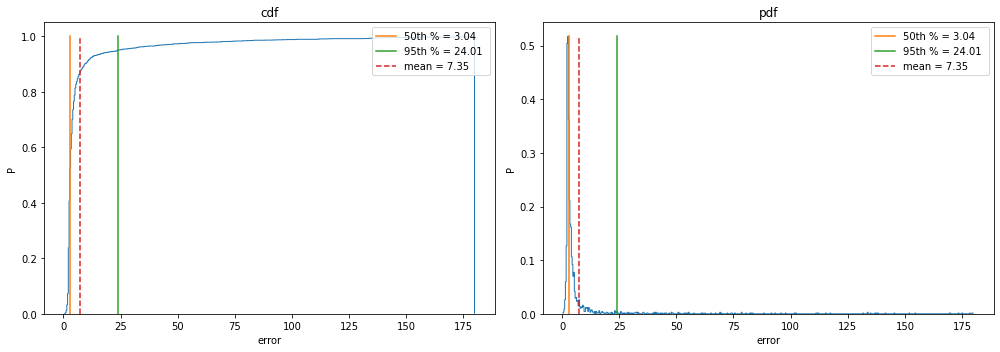

In [12]:
angular_errrs = error_plot(Ts[:, :3, :3], T_hats[:, :3, :3], metric=angular_distances)



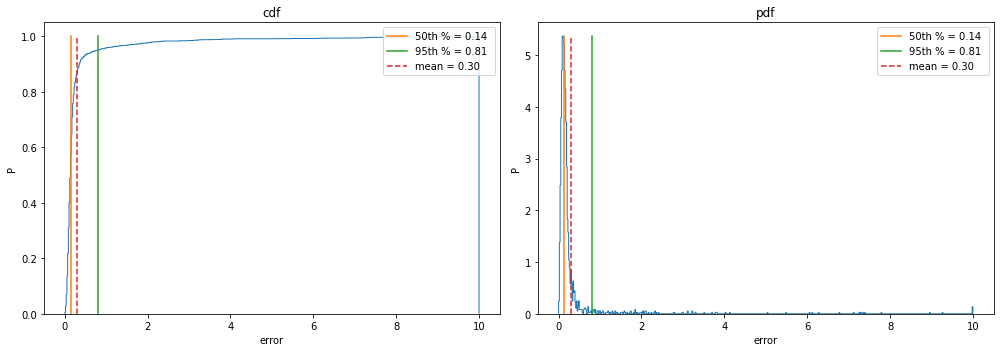

In [13]:
linear_errrs = error_plot(Ts[:, :3, 3], T_hats[:, :3, 3], max_err_clip=10)



In [ ]:
import json

io.save('./final_test_CUT.json', np.asarray(T_hats))
    

In [ ]:
file = open(r"final_test.txt","w")

for i in range(len(angular_errrs)):
    file.write('%.3f' % angular_errrs[i])
    file.write(', ')
    file.write('%.3f' % linear_errrs[i])
    file.write('\n')
    
file.close()

In [ ]:
T_hats

In [ ]:
Ts